# Feature engineering

В предишната тетрадка опитахме различни неща с модела. Но семплирането на модела не даде смислен резултат.

Ще опитаме да направим по-добри (и повече) feature-и за всяка от плочките и да оставим невронната мрежа да си сврърши работата.

Нека заредим малко модули и данни...

In [2]:
import numpy as np
import os
import random
import sys

sys.path.append('../model')

import config
from scenario import *
from tileset import *
from mdlstm import *

from time import time

import tensorflow.contrib.slim as slim

In [3]:
scenarios = []
scenarios += process_scenarios(os.path.join(config.STARCRAFT_ROOT, 'Maps'))
for directory in config.MAP_DIRECTORIES:
    scenarios += process_scenarios(directory)

tiny_jungle_scenarios = [x for x in scenarios if x.alliances == x.human_players == 2 and x.tileset == Tileset.JUNGLE and x.width == x.height == 64]

len(scenarios)

561

In [4]:
import matplotlib.pyplot as plt

## Идея 1: feature-и от свойства на плочки?

Интуитивен начин да направим feature-и би бил да вземем всички 16 мини-плочки, от които е направена всяка плочка. На базата на свойствата на тези мини-плочки и на свойствата на самата плочка можем да направим векторите ни с feature-и.

След известно ровене в плочките забелязваме нещо...

1074 0
[[0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333 0.33333333]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


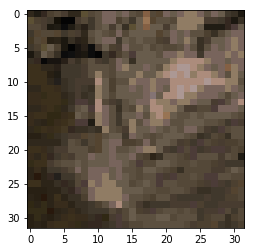

In [5]:
lost_temple = next(filter(lambda x: x.name == 'The Lost Temple', scenarios))

plt.imshow(lost_temple.tiles[65, 8].graphics)
print(lost_temple.tiles[65, 8].index // 16, lost_temple.tiles[65, 8].index % 16)
print(np.vectorize(lambda x: x.height)(lost_temple.tiles[65, 8].minitiles))
print(np.vectorize(lambda x: x.ramp)(lost_temple.tiles[65, 8].minitiles))

Това е част от изкачване от "lowground" към "highground". Свойствата му са напълно безполезни. На практика не можем да използваме височината на плочката като feature. Нито флага `ramp`. Други флагове може би ще идентифицират плочката, но едва ли ще бъде достатъчно за уникална идентификация.

## Идея 2: One hot encoding (with a twist)

При имплементацията на парсера за `Tileset` данни, забелязваме че има два типа плочки. Първите са нормални части от терена. Вторите са "нещица" (doodads) разхвърляни по картата.

Първите са разпръснати в групи от по до 16 плочки. Свойствата им са еднотипни в рамките на групата. Разликата е единствено във визуализацията им. Плочките в една група са взаимнозаменяеми.

Вторите обикновено са препятствия по терена, чиято графика е по-голяма от размерите на единична плочка. За да се получи "нещото", плочките му трябва да бъдат използвани в конкретен ред. Плочките от този тип също са в групи, но плочките не са взаимнозаменяеми в рамките на група.

Идеята е плочките от първи тип да кодираме като `(уникален-номер-на-група, позиция-в-групата)`, а плочките от втори тип като `(уникален-номер-на-плочка, 0.5)`, където `уникален-номер-на-група` и `уникален-номер-на-плочка` са две непресичащи се множества от последователни цели числа.

In [6]:
tiles = Tileset.JUNGLE.tiles
terrain_tiles = (tile for tile in tiles if not tile.is_empty and not tile.is_doodad)
doodad_tiles = (tile for tile in tiles if not tile.is_empty and tile.is_doodad)

groups = dict()
tile_features = dict()

for tile in terrain_tiles:
    if not tile.group_id in groups:
        groups[tile.group_id] = len(groups)
    tile_features[tile] = (groups[tile.group_id], (tile.group_offset + 1) / 16)

group_count = len(groups)
del(groups)
for tile in doodad_tiles:
    group_count += 1
    tile_features[tile] = (group_count, 0.5)

In [7]:
print(group_count)

2413


В момента сме кодирали всяка плочка с двойка числа (x, y), където x ∈ [0-2413), y ∈ (0-1]. Може да се каже, че при втория параметър има някаква наредба. При вървият обаче - не. Ще му направим one hot encoding.

In [8]:
one_hot_tile_features = dict()

for tile, (group_id, group_offset) in tile_features.items():
    one_hot_tile_features[tile] = np.zeros(group_count + 1)
    one_hot_tile_features[tile][group_id] = 1.0
    one_hot_tile_features[tile][-1] = group_offset

del tile_features

## Помощни функции

Ще напишем функции, които обръщат плочка във вектор и обратно

In [9]:
h = 64
w = 64

tile_vec_size = group_count + 1
input_vec_size = 2 * tile_vec_size
output_vec_size = tile_vec_size

learning_rate = 0.05
batch_size = 7
hidden_size = 128
dtype = tf.float32

In [10]:
def tile_to_output(tiles, vertical_index, horizontal_index):
    if vertical_index >= 0 and horizontal_index >= 0:
        tile = tiles[vertical_index, horizontal_index]
        return np.array(one_hot_tile_features[tile])
    else:
        return np.zeros([tile_vec_size])

In [11]:
tile_to_output(lost_temple.tiles, 65, 8).shape

(2414,)

In [12]:
def tile_to_input(tiles, vertical_index, horizontal_index):
    top_features = tile_to_output(tiles, vertical_index - 1, horizontal_index)
    left_features = tile_to_output(tiles, vertical_index, horizontal_index - 1)
    return np.concatenate([top_features, left_features])

In [13]:
tile_to_input(lost_temple.tiles, 65, 8).shape

(4828,)

## Трениране

In [14]:
data = tiny_jungle_scenarios[:]

def batches(data, batch_size, epochs):
    all_batches = []
    for epoch in range(epochs):
        random.shuffle(data)
        all_batches += data

    for i in range(0, epochs * len(data), batch_size):
        inputs = all_batches[i: i + batch_size]
        if len(inputs) == batch_size:
            yield inputs

In [15]:
def scenario_to_input(scenario):
    x = np.empty((h, w, input_vec_size), dtype=np.float32)
    for vertical_index in range(h):
        for horizontal_index in range(w):
            x[vertical_index, horizontal_index, :] = tile_to_input(scenario.tiles, vertical_index, horizontal_index)
    return x

def scenario_to_output(scenario):
    y = np.empty((h, w, output_vec_size), dtype=np.float32)
    for vertical_index in range(h):
        for horizontal_index in range(w):
            y[vertical_index, horizontal_index, :] = tile_to_output(scenario.tiles, vertical_index, horizontal_index)
    return y

In [64]:
with tf.variable_scope('a', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    epochs = 10
    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([scenario_to_input(scenario) for scenario in batch]),
            y: np.stack([scenario_to_output(scenario) for scenario in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break
            
        step += 1

steps = 0000 | overall loss = 0.25002 | time 82.991
steps = 0001 | overall loss = 0.24672 | time 82.043
steps = 0002 | overall loss = 0.14108 | time 82.081
steps = 0003 | overall loss = 0.05703 | time 82.827
steps = 0004 | overall loss = 0.01717 | time 83.419
steps = 0005 | overall loss = 0.00428 | time 83.299
steps = 0006 | overall loss = 0.00120 | time 84.872
steps = 0007 | overall loss = 0.00060 | time 88.891
steps = 0008 | overall loss = 0.00046 | time 85.054
steps = 0009 | overall loss = 0.00044 | time 83.952
steps = 0010 | overall loss = 0.00044 | time 83.884
steps = 0011 | overall loss = 0.00044 | time 84.732
steps = 0012 | overall loss = 0.00043 | time 83.350
steps = 0013 | overall loss = 0.00043 | time 84.407
steps = 0014 | overall loss = 0.00043 | time 84.061


## Трениране (2)

Нека пробваме с по-мощен модел

In [67]:
learning_rate = 0.05
batch_size = 7
hidden_size = 256
epochs = 10
dtype = tf.float32

with tf.variable_scope('b', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([scenario_to_input(scenario) for scenario in batch]),
            y: np.stack([scenario_to_output(scenario) for scenario in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break
            
        step += 1

steps = 0000 | overall loss = 0.25015 | time 166.358
steps = 0001 | overall loss = 0.23416 | time 162.939
steps = 0002 | overall loss = 0.14470 | time 171.705
steps = 0003 | overall loss = 0.05566 | time 168.984
steps = 0004 | overall loss = 0.01478 | time 169.868
steps = 0005 | overall loss = 0.00360 | time 166.917
steps = 0006 | overall loss = 0.00106 | time 164.875
steps = 0007 | overall loss = 0.00056 | time 164.821
steps = 0008 | overall loss = 0.00045 | time 163.631
steps = 0009 | overall loss = 0.00043 | time 163.015
steps = 0010 | overall loss = 0.00043 | time 161.368
steps = 0011 | overall loss = 0.00043 | time 163.613
steps = 0012 | overall loss = 0.00043 | time 161.678
steps = 0013 | overall loss = 0.00043 | time 167.323
steps = 0014 | overall loss = 0.00043 | time 164.903
steps = 0015 | overall loss = 0.00043 | time 166.771
steps = 0016 | overall loss = 0.00043 | time 169.588
steps = 0017 | overall loss = 0.00043 | time 165.708
steps = 0018 | overall loss = 0.00043 | time 1

Никаква разлика. Освен, че тренирането е по-бавно.

Нека пробваме с по-слаб модел.

In [69]:
learning_rate = 0.1
batch_size = 7
hidden_size = 64
epochs = 15
dtype = tf.float32

with tf.variable_scope('c', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([scenario_to_input(scenario) for scenario in batch]),
            y: np.stack([scenario_to_output(scenario) for scenario in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break
        step += 1

steps = 0000 | overall loss = 0.24997 | time 58.945
steps = 0001 | overall loss = 0.19991 | time 59.939
steps = 0002 | overall loss = 0.08415 | time 59.391
steps = 0003 | overall loss = 0.01876 | time 59.778
steps = 0004 | overall loss = 0.00287 | time 60.606
steps = 0005 | overall loss = 0.00069 | time 60.071
steps = 0006 | overall loss = 0.00045 | time 59.837
steps = 0007 | overall loss = 0.00043 | time 61.731
steps = 0008 | overall loss = 0.00043 | time 60.149
steps = 0009 | overall loss = 0.00044 | time 60.770
steps = 0010 | overall loss = 0.00043 | time 58.467
steps = 0011 | overall loss = 0.00043 | time 59.654
steps = 0012 | overall loss = 0.00044 | time 59.695
steps = 0013 | overall loss = 0.00044 | time 59.330
steps = 0014 | overall loss = 0.00044 | time 59.688
steps = 0015 | overall loss = 0.00044 | time 60.034
steps = 0016 | overall loss = 0.00043 | time 60.078
steps = 0017 | overall loss = 0.00043 | time 61.213
steps = 0018 | overall loss = 0.00043 | time 60.310
steps = 0019

In [152]:
learning_rate = 0.1
batch_size = 7
hidden_size = 32
epochs = 10
dtype = tf.float32

with tf.variable_scope('d', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [None, h, w, input_vec_size])
    y = tf.placeholder(dtype, [None, h, w, output_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    loss = tf.reduce_mean(tf.square(y - model_out))
    grad_update = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    sess.run(tf.global_variables_initializer())

    step = 0
    for batch in batches(data, batch_size, epochs):
        grad_step_start_time = time()

        model_preds, tot_loss_value, _ = sess.run([model_out, loss, grad_update], feed_dict={
            x: np.stack([scenario_to_input(scenario) for scenario in batch]),
            y: np.stack([scenario_to_output(scenario) for scenario in batch]),
        })

        print('steps = {0} | overall loss = {1:.5f} | time {2:.3f}'.format(
            str(step).zfill(4),
            tot_loss_value,
            time() - grad_step_start_time))

        if tot_loss_value != tot_loss_value:
            break
        step += 1

steps = 0000 | overall loss = 0.24999 | time 74.470
steps = 0001 | overall loss = 0.21263 | time 67.603
steps = 0002 | overall loss = 0.11049 | time 67.623
steps = 0003 | overall loss = 0.04579 | time 68.911
steps = 0004 | overall loss = 0.01196 | time 68.554
steps = 0005 | overall loss = 0.00284 | time 69.003
steps = 0006 | overall loss = 0.00089 | time 69.409
steps = 0007 | overall loss = 0.00052 | time 68.980
steps = 0008 | overall loss = 0.00044 | time 72.038
steps = 0009 | overall loss = 0.00043 | time 68.920
steps = 0010 | overall loss = 0.00043 | time 69.534
steps = 0011 | overall loss = 0.00043 | time 68.089
steps = 0012 | overall loss = 0.00043 | time 69.379
steps = 0013 | overall loss = 0.00043 | time 69.769
steps = 0014 | overall loss = 0.00043 | time 69.232


Същото. Но се тренира по-бързо. Нека видим какво се случва всъщност.

## Семплиране на модела

Да разглеждаме какво се случва...

In [18]:
def iterate_by_layers(height, width):
    
    def iterate_layer(layer):
        for x in range(layer + 1):
            y = layer - x
            if 0 <= x < width and 0 <= y < height:
                yield (x, y)

    for layer in range(width + height - 1):
        yield iterate_layer(layer)

In [35]:
with tf.variable_scope('d', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [1, h, w, input_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    inputs = np.zeros([1, 64, 64, input_vec_size])
    ouputs = np.zeros([1, 64, 64, output_vec_size])
    
    for layer in iterate_by_layers(64, 64):
        l = list(layer)
        for i, j in l:
            inputs[0, i, j, 0:output_vec_size] = ouputs[0, i - 1, j, :]
            inputs[0, i, j, output_vec_size:2*output_vec_size] = ouputs[0, i, j - 1, :]
            
        model_preds = sess.run(model_out, feed_dict={ x: inputs })

        break

In [36]:
model_preds[0, 0, 0, :-1]

array([0.00335262, 0.00432778, 0.00388061, ..., 0.00361095, 0.00372539,
       0.00353912], dtype=float32)

In [37]:
sum(model_preds[0, 0, 0, :-1])

8.161744204582646

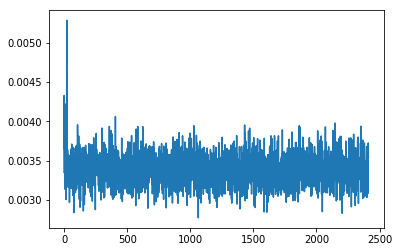

In [38]:
plt.plot(model_preds[0, 0, 0, :-1])

In [48]:
ind = np.argmax(model_preds[0, 0, 0, :-1])
ind

22

In [49]:
model_preds[0, 0, 0, -1]

0.18066552

In [73]:
tiles = { features[-1]: tile for tile, features in one_hot_tile_features.items() if features[ind] == 1 }
_, tile = min(tiles.items(), key=lambda x: abs(x[0] - model_preds[0, 0, 0, -1]))
tile

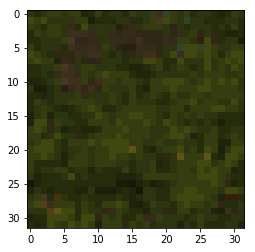

In [71]:
plt.imshow(tile.graphics)

In [72]:
one_hot_tile_features[tile]

array([0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.1875])

Нека опитаме да семплираме модела. Итеративно ще го караме да ни дава нови плочки слой по слой.

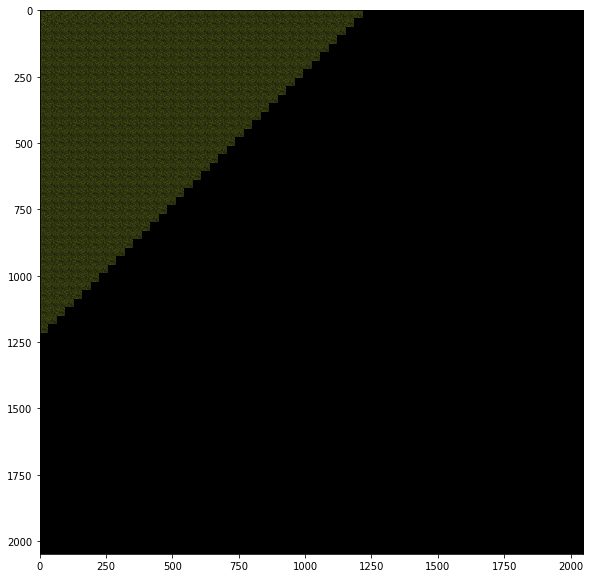

KeyboardInterrupt: 

In [146]:
import graphics
from IPython.display import clear_output

%matplotlib inline

with tf.variable_scope('d', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [1, h, w, input_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    inputs = np.zeros([1, 64, 64, input_vec_size])
    output_tiles = np.full([64, 64], Tileset.JUNGLE.tiles[0], dtype=object)

    for layer in iterate_by_layers(64, 64):
        l = list(layer)
        for i, j in l:
            inputs[0, i, j] = tile_to_input(output_tiles, i, j)
            
        model_preds = sess.run(model_out, feed_dict={ x: inputs })

        for i, j in l:
            group_id = np.argmax(model_preds[0, i, j, 10:-1])
            group_offset_tiles = { features[-1]: tile for tile, features in one_hot_tile_features.items() if features[group_id] == 1 }
            _, tile = min(group_offset_tiles.items(), key=lambda x: abs(x[0] - model_preds[0, i, j, -1]))
            output_tiles[i, j] = tile

        clear_output()
        plt.figure(figsize=(10, 10))
        plt.imshow(graphics.tile(output_tiles))
        plt.show()

Научил се е единствено да показва май-често срещатаната плочка.

Да оставим това за момент. Какво би показал модела, ако му дадем реално съществуваща карта и за всеки две плочки поискаме следващата?

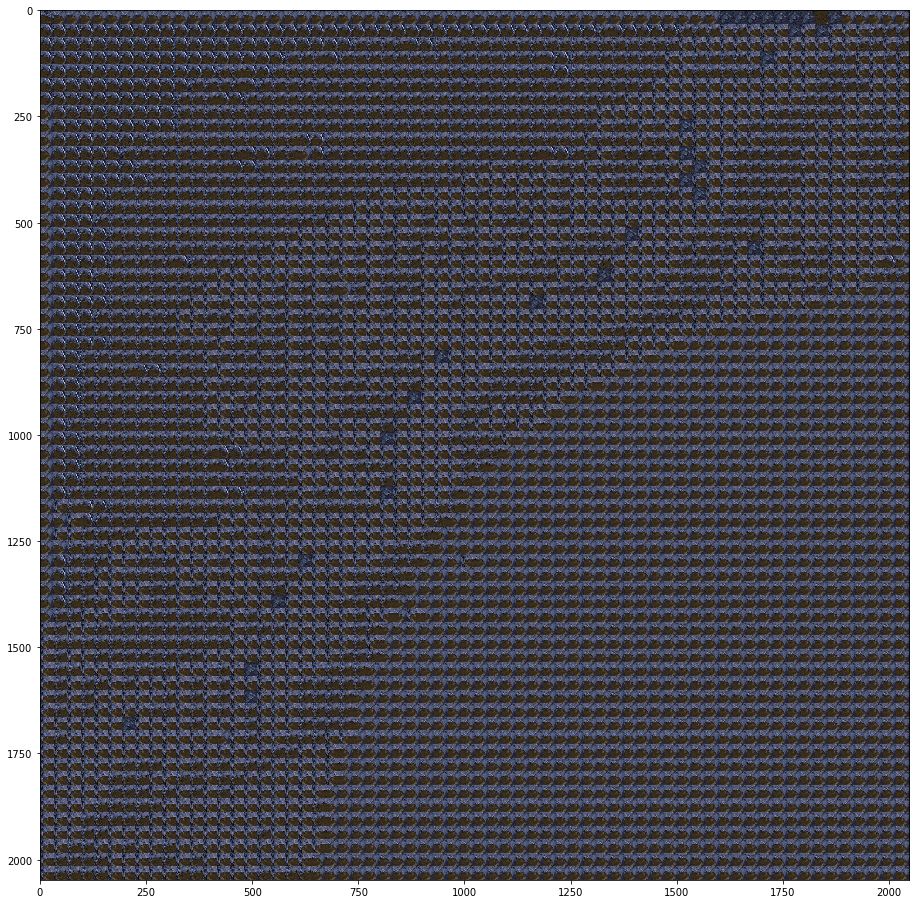

In [180]:
import graphics
from IPython.display import clear_output

%matplotlib inline

with tf.variable_scope('d', reuse=tf.AUTO_REUSE):
    x = tf.placeholder(dtype, [1, h, w, input_vec_size])

    mdrnn_while_loop = MdRnnWhileLoop(dtype)
    rnn_out, _ = mdrnn_while_loop(rnn_size=hidden_size, input_data=x)
    model_out = slim.fully_connected(inputs=rnn_out, num_outputs=output_vec_size, activation_fn=tf.nn.sigmoid)

    inputs = scenario_to_input(tiny_jungle_scenarios[0]).reshape([1, 64, 64, input_vec_size])
    output_tiles = np.full([64, 64], Tileset.JUNGLE.tiles[0], dtype=object)

    model_preds = sess.run(model_out, feed_dict={ x: inputs })
    
    for i in range(64):
        for j in range(64):
            group_id = np.argmax(model_preds[0, i, j, 25:-1])
            group_offset_tiles = { features[-1]: tile for tile, features in one_hot_tile_features.items() if features[group_id] == 1 }
            _, tile = min(group_offset_tiles.items(), key=lambda x: abs(x[0] - model_preds[0, i, j, -1]))
            output_tiles[i, j] = tile

    plt.figure(figsize=(16, 16))
    plt.imshow(graphics.tile(output_tiles))
    plt.show()

Ъгх. Изглежда моделът просто се научава да повтаря едно и също. Това се случва с RNN. LSTM попринцип би трябвало да оправя този проблем. Решението са по-дълги последователности, по-големи batch-ове, и по-голям learning rate. Но всяко от тях води до числена нестабилност. Изглежда сме в задънена улица.